# Introduction

Along this notebook I will develop a MACD indicator with trading-signals notification capabilities in Python. Based on Talib package, and structured as a python Class, this listener will generate market signals depending on some features from MACD indicator, such as:

- **Upwards and downwards crossovers between MACD main and signal lines**: these crossovers should warn about a possible correction in the current trend.
- **Upwards and downwards crossovers between MACD main line and zero level**: these crossovers should warn about a change of trend.
- **Bearish and bullish divergence patterns**: these patterns should warn about a loss of strength in the current trend.

Let's start!!


In [1]:
import sys

####################################################################################
# Data handling 
import pandas as pd
from pandas import concat
from pandas.plotting import scatter_matrix
import numpy as np

####################################################################################
# Visualization
import matplotlib.pyplot as plt
from matplotlib import dates, ticker
from matplotlib.dates import (MONDAY, DateFormatter, MonthLocator, WeekdayLocator, date2num)
import matplotlib as mpl
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import *
from plotly.tools import FigureFactory as FF
import plotly.tools as tls
plotly.offline.init_notebook_mode(connected=True)

####################################################################################
# TA-Lib: 
import talib

####################################################################################
# Other utilities
import datetime
import time
import os
import sys
import math
from enum import Enum

print('Packages loaded!!')

Packages loaded!!


## Step 1. Load a financial instrument data feed for testing purposes

In this case I load a data feed from Forex pair EURUSD at timeframe M15 (previously downloaded from the trading platform). Data has been previosly curated, and can be loaded into a pandas.dataframe. In this case I only select OHLC columns to calculate MACD later:


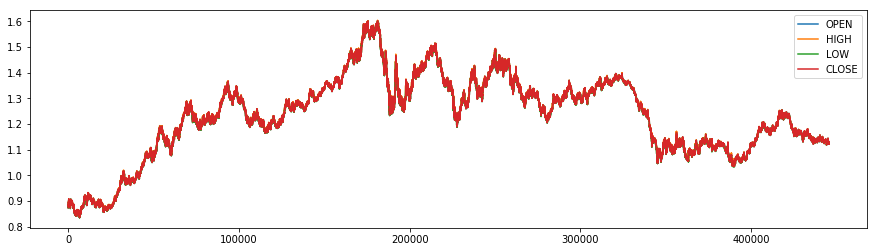

In [3]:
# Load instrument's data feed and visualize columns
df = pd.read_csv('../csv_data/EURUSD_M15.csv', sep=';')
df = df[['OPEN','HIGH','LOW','CLOSE']]
df.plot(figsize=(15,4))

## Step 2. Add MACD indicator

Now, let's add MACD indicator with default parameters, which provides these columns:

- MACD: MACD main line
- MACDS: MACD signal line
- MACDH: MACD histogram

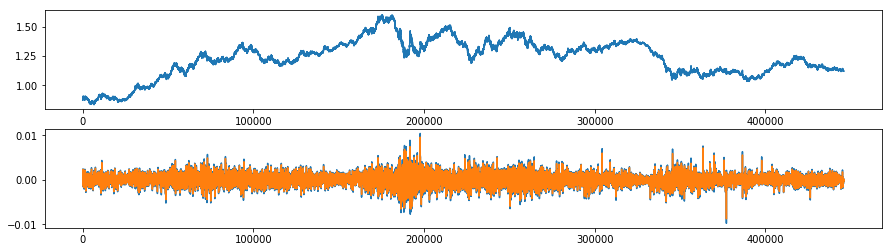

In [4]:
# add MACD main, signal and histogram
df['MACD'], df['MACDS'], df['MACDH'] = talib.MACD(df.CLOSE, fastperiod=12, slowperiod=26, signalperiod=9)

# remove NaNs on moving averages calculation
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# plot closing price
plt.figure(figsize=(15,4))
plt.subplot(2,1,1)
plt.plot(df.CLOSE)

# plot MACD main and signal lines
plt.subplot(2,1,2)
plt.plot(df.MACD, label='MACD')
plt.plot(df.MACDS, label='MACD_Sig')

## Step 3: Add most popular trading-signals detectors

Now, let's add several columns for the most popular MACD trading-signals, explained before:

- CROSS_SIG_UP: Upwards crossover between main and signal line
- CROSS_SIG_DN: Downwards crossover between main and signal line
- CROSS_ZERO_UP: Upwards crossover between main and zero level
- CROSS_ZERO_DN: Downwards crossover between main and zero level
- DIV_BEAR: Bearish divergence pattern 
- DIV_BULL: Bullish divergence pattern 

In [6]:
df['CROSS_ZERO_UP'] = ((df.MACD > 0) & (df.MACD.shift(1) < 0 | ((df.MACD.shift(1)==0) & (df.MACD.shift(2) < 0))))
print('Num rows where cross_sig_up is raised is = {}'.format(df[df['CROSS_ZERO_UP'] == True].shape[0]))

Num rows where cross_sig_up is raised is = 7914


In [7]:
df['CROSS_ZERO_DN'] = ((df.MACD < 0) & (df.MACD.shift(1) > 0 | ((df.MACD.shift(1)==0) & (df.MACD.shift(2) > 0))))
print('Num rows where cross_sig_dn is raised is = {}'.format(df[df['CROSS_ZERO_DN'] == True].shape[0]))

Num rows where cross_sig_dn is raised is = 7915


In [8]:
df['CROSS_SIG_UP'] = (((df.MACD > df.MACDS) & ((df.MACD.shift(1) < df.MACDS.shift(1)) | ((df.MACD.shift(1)==df.MACDS.shift(1)) & (df.MACD.shift(2) < df.MACDS.shift(2))))) & ((df.MACD < 0) & (df.MACD.shift(1) < 0) & (df.MACD.shift(2) < 0)))
print('Num rows where cross_sig_up is raised is = {}'.format(df[df['CROSS_SIG_UP'] == True].shape[0]))

Num rows where cross_sig_up is raised is = 10831


In [9]:
df['CROSS_SIG_DN'] = (((df.MACD < df.MACDS) & ((df.MACD.shift(1) > df.MACDS.shift(1)) | ((df.MACD.shift(1)==df.MACDS.shift(1)) & (df.MACD.shift(2) > df.MACDS.shift(2))))) & ((df.MACD > 0) & (df.MACD.shift(1) > 0) & (df.MACD.shift(2) > 0)))
print('Num rows where cross_sig_dn is raised is = {}'.format(df[df['CROSS_SIG_DN'] == True].shape[0]))

Num rows where cross_sig_dn is raised is = 10953


Let's calculate the bearish divergence signals, that include multiple steps:

1a) Bearish: MACD main line max value in a swing from last zero level upwards crossover to a downwards crossover with signal line, above zero level:

In [83]:
# CONFIG: Min number of bars in a swing
CONFIG_MIN_BARS_ON_SWING = 5

# bars with upwards crossover
swing_start = df['CROSS_ZERO_UP'] 

# bars with downwards crossover above zero
swing_stop = df['CROSS_ZERO_DN'] #((df.MACD > 0) & (df.MACD < df.MACDS) & ((df.MACD.shift(1) > df.MACDS.shift(1)) | ((df.MACD.shift(1)==df.MACDS.shift(1)) & (df.MACD.shift(2) > df.MACDS.shift(2)))))

# indexes where crossovers occurs
swing_start_idx = swing_start[swing_start == True]
swing_stop_idx = swing_stop[swing_stop == True]

# ensures first valid swing
swing_stop_idx  = swing_stop_idx[swing_stop_idx.index > swing_start_idx.index[0]]

# now, builds column with macd_max points  
df['MACD_MAX'] = False

# for each downwards crossover, searches previous upwards crossover
for dn_cross in swing_stop_idx.index:
  prev_up_cross = swing_start_idx[swing_start_idx.index < dn_cross].index[-1]
  if dn_cross-prev_up_cross < CONFIG_MIN_BARS_ON_SWING:
    print('Bearish-swing discarded between {} and {}'.format(prev_up_cross, dn_cross))
  else:
    idx_max_val = df.MACD[prev_up_cross:dn_cross].idxmax()
    df['MACD_MAX'].at[idx_max_val] = True  

Bearish-swing discarded between 949 and 953
Bearish-swing discarded between 1523 and 1524
Bearish-swing discarded between 1818 and 1822
Bearish-swing discarded between 2235 and 2238
Bearish-swing discarded between 2284 and 2285
Bearish-swing discarded between 2345 and 2347
Bearish-swing discarded between 2397 and 2399
Bearish-swing discarded between 2588 and 2591
Bearish-swing discarded between 2771 and 2772
Bearish-swing discarded between 2885 and 2888
Bearish-swing discarded between 2940 and 2941
Bearish-swing discarded between 3423 and 3424
Bearish-swing discarded between 3454 and 3457
Bearish-swing discarded between 3458 and 3460
Bearish-swing discarded between 3548 and 3550
Bearish-swing discarded between 3763 and 3767
Bearish-swing discarded between 4251 and 4252
Bearish-swing discarded between 5467 and 5468
Bearish-swing discarded between 5477 and 5481
Bearish-swing discarded between 7093 and 7094
Bearish-swing discarded between 7534 and 7536
Bearish-swing discarded between 7667

Bearish-swing discarded between 51036 and 51039
Bearish-swing discarded between 51041 and 51042
Bearish-swing discarded between 51245 and 51246
Bearish-swing discarded between 51440 and 51444
Bearish-swing discarded between 52006 and 52009
Bearish-swing discarded between 52462 and 52465
Bearish-swing discarded between 52737 and 52739
Bearish-swing discarded between 53032 and 53036
Bearish-swing discarded between 53186 and 53189
Bearish-swing discarded between 53758 and 53762
Bearish-swing discarded between 53842 and 53843
Bearish-swing discarded between 53953 and 53954
Bearish-swing discarded between 53955 and 53956
Bearish-swing discarded between 55213 and 55217
Bearish-swing discarded between 55399 and 55400
Bearish-swing discarded between 55467 and 55470
Bearish-swing discarded between 55471 and 55472
Bearish-swing discarded between 56437 and 56438
Bearish-swing discarded between 56669 and 56671
Bearish-swing discarded between 57025 and 57027
Bearish-swing discarded between 57402 an

Bearish-swing discarded between 132082 and 132083
Bearish-swing discarded between 132316 and 132317
Bearish-swing discarded between 132626 and 132630
Bearish-swing discarded between 132784 and 132785
Bearish-swing discarded between 133300 and 133302
Bearish-swing discarded between 133457 and 133458
Bearish-swing discarded between 133817 and 133818
Bearish-swing discarded between 134108 and 134112
Bearish-swing discarded between 134361 and 134362
Bearish-swing discarded between 134613 and 134617
Bearish-swing discarded between 134806 and 134808
Bearish-swing discarded between 134966 and 134967
Bearish-swing discarded between 135358 and 135359
Bearish-swing discarded between 135625 and 135626
Bearish-swing discarded between 135646 and 135648
Bearish-swing discarded between 135651 and 135655
Bearish-swing discarded between 135656 and 135660
Bearish-swing discarded between 135764 and 135765
Bearish-swing discarded between 135766 and 135768
Bearish-swing discarded between 137005 and 137009


Bearish-swing discarded between 187561 and 187564
Bearish-swing discarded between 187835 and 187837
Bearish-swing discarded between 187851 and 187853
Bearish-swing discarded between 188664 and 188665
Bearish-swing discarded between 189473 and 189475
Bearish-swing discarded between 189572 and 189574
Bearish-swing discarded between 190341 and 190343
Bearish-swing discarded between 190617 and 190620
Bearish-swing discarded between 190804 and 190805
Bearish-swing discarded between 192972 and 192975
Bearish-swing discarded between 193479 and 193483
Bearish-swing discarded between 193502 and 193503
Bearish-swing discarded between 193893 and 193895
Bearish-swing discarded between 194296 and 194299
Bearish-swing discarded between 195088 and 195092
Bearish-swing discarded between 195433 and 195437
Bearish-swing discarded between 196372 and 196376
Bearish-swing discarded between 196647 and 196649
Bearish-swing discarded between 196868 and 196870
Bearish-swing discarded between 197463 and 197466


Bearish-swing discarded between 269683 and 269686
Bearish-swing discarded between 269956 and 269959
Bearish-swing discarded between 270211 and 270213
Bearish-swing discarded between 270216 and 270219
Bearish-swing discarded between 270774 and 270775
Bearish-swing discarded between 270799 and 270801
Bearish-swing discarded between 270929 and 270933
Bearish-swing discarded between 271566 and 271568
Bearish-swing discarded between 271921 and 271923
Bearish-swing discarded between 271985 and 271986
Bearish-swing discarded between 272466 and 272467
Bearish-swing discarded between 272469 and 272470
Bearish-swing discarded between 272545 and 272549
Bearish-swing discarded between 272773 and 272775
Bearish-swing discarded between 273101 and 273103
Bearish-swing discarded between 273104 and 273106
Bearish-swing discarded between 273246 and 273249
Bearish-swing discarded between 273254 and 273257
Bearish-swing discarded between 273457 and 273458
Bearish-swing discarded between 273975 and 273977


Bearish-swing discarded between 322734 and 322736
Bearish-swing discarded between 322981 and 322982
Bearish-swing discarded between 323671 and 323673
Bearish-swing discarded between 323694 and 323695
Bearish-swing discarded between 324103 and 324107
Bearish-swing discarded between 324425 and 324426
Bearish-swing discarded between 324867 and 324869
Bearish-swing discarded between 324916 and 324919
Bearish-swing discarded between 324932 and 324935
Bearish-swing discarded between 325117 and 325120
Bearish-swing discarded between 325529 and 325533
Bearish-swing discarded between 326155 and 326156
Bearish-swing discarded between 326160 and 326163
Bearish-swing discarded between 326358 and 326360
Bearish-swing discarded between 326539 and 326543
Bearish-swing discarded between 326895 and 326896
Bearish-swing discarded between 327047 and 327051
Bearish-swing discarded between 327189 and 327191
Bearish-swing discarded between 328034 and 328037
Bearish-swing discarded between 329012 and 329013


Bearish-swing discarded between 376439 and 376440
Bearish-swing discarded between 376761 and 376765
Bearish-swing discarded between 377396 and 377400
Bearish-swing discarded between 377649 and 377650
Bearish-swing discarded between 377652 and 377655
Bearish-swing discarded between 377664 and 377665
Bearish-swing discarded between 378009 and 378010
Bearish-swing discarded between 378291 and 378295
Bearish-swing discarded between 378430 and 378432
Bearish-swing discarded between 378435 and 378437
Bearish-swing discarded between 378841 and 378845
Bearish-swing discarded between 378965 and 378968
Bearish-swing discarded between 380179 and 380183
Bearish-swing discarded between 380474 and 380475
Bearish-swing discarded between 380635 and 380638
Bearish-swing discarded between 381310 and 381312
Bearish-swing discarded between 381448 and 381449
Bearish-swing discarded between 381451 and 381452
Bearish-swing discarded between 382269 and 382272
Bearish-swing discarded between 382779 and 382780


Bearish-swing discarded between 433510 and 433513
Bearish-swing discarded between 433950 and 433952
Bearish-swing discarded between 434310 and 434313
Bearish-swing discarded between 434783 and 434784
Bearish-swing discarded between 435241 and 435243
Bearish-swing discarded between 435414 and 435415
Bearish-swing discarded between 435537 and 435538
Bearish-swing discarded between 436151 and 436154
Bearish-swing discarded between 436308 and 436311
Bearish-swing discarded between 437577 and 437578
Bearish-swing discarded between 437579 and 437581
Bearish-swing discarded between 438215 and 438219
Bearish-swing discarded between 438326 and 438329
Bearish-swing discarded between 438608 and 438609
Bearish-swing discarded between 438728 and 438729
Bearish-swing discarded between 438773 and 438776
Bearish-swing discarded between 439250 and 439253
Bearish-swing discarded between 439679 and 439680
Bearish-swing discarded between 439721 and 439724
Bearish-swing discarded between 440237 and 440238


1b) Bullish: MACD main line min value in a swing from last zero level downwards crossover to an upwards crossover with signal line below zero level:

In [84]:
# bars with upwards crossover
bull_swing_start = df['CROSS_ZERO_DN'] 

# bars with upwards crossover below zero
bull_swing_stop = df['CROSS_ZERO_UP'] #((df.MACD < 0) & (df.MACD > df.MACDS) & ((df.MACD.shift(1) < df.MACDS.shift(1)) | ((df.MACD.shift(1)==df.MACDS.shift(1)) & (df.MACD.shift(2) < df.MACDS.shift(2)))))

# indexes where crossovers occurs
bull_swing_start_idx = bull_swing_start[bull_swing_start == True]
bull_swing_stop_idx = bull_swing_stop[bull_swing_stop == True]

# ensures first valid swing
bull_swing_stop_idx  = bull_swing_stop_idx[bull_swing_stop_idx.index > bull_swing_start_idx.index[0]]

# now, builds column with macd_min points  
df['MACD_MIN'] = False

# for each upwards crossover, searches previous downwards crossover
for up_cross in bull_swing_stop_idx.index:
  prev_dn_cross = bull_swing_start_idx[bull_swing_start_idx.index < up_cross].index[-1]
  if up_cross-prev_dn_cross < CONFIG_MIN_BARS_ON_SWING:
    print('Bullish-swing discarded between {} and {}'.format(prev_dn_cross, up_cross))
  else:
    idx_min_val = df.MACD[prev_dn_cross:up_cross].idxmin()
    df['MACD_MIN'].at[idx_min_val] = True  

Bullish-swing discarded between 253 and 255
Bullish-swing discarded between 948 and 949
Bullish-swing discarded between 1365 and 1369
Bullish-swing discarded between 1682 and 1686
Bullish-swing discarded between 1817 and 1818
Bullish-swing discarded between 2342 and 2345
Bullish-swing discarded between 2347 and 2349
Bullish-swing discarded between 2399 and 2400
Bullish-swing discarded between 3419 and 3423
Bullish-swing discarded between 3457 and 3458
Bullish-swing discarded between 3547 and 3548
Bullish-swing discarded between 3648 and 3652
Bullish-swing discarded between 3887 and 3888
Bullish-swing discarded between 4229 and 4233
Bullish-swing discarded between 5562 and 5564
Bullish-swing discarded between 5783 and 5785
Bullish-swing discarded between 6463 and 6466
Bullish-swing discarded between 6853 and 6857
Bullish-swing discarded between 7536 and 7540
Bullish-swing discarded between 7577 and 7580
Bullish-swing discarded between 8010 and 8011
Bullish-swing discarded between 8013 a

Bullish-swing discarded between 77181 and 77183
Bullish-swing discarded between 77804 and 77805
Bullish-swing discarded between 77810 and 77814
Bullish-swing discarded between 77953 and 77955
Bullish-swing discarded between 78166 and 78167
Bullish-swing discarded between 78423 and 78425
Bullish-swing discarded between 79279 and 79280
Bullish-swing discarded between 79282 and 79284
Bullish-swing discarded between 79394 and 79396
Bullish-swing discarded between 79780 and 79783
Bullish-swing discarded between 81266 and 81268
Bullish-swing discarded between 81531 and 81535
Bullish-swing discarded between 81812 and 81814
Bullish-swing discarded between 81922 and 81926
Bullish-swing discarded between 82323 and 82324
Bullish-swing discarded between 82325 and 82326
Bullish-swing discarded between 82501 and 82502
Bullish-swing discarded between 82771 and 82775
Bullish-swing discarded between 82908 and 82910
Bullish-swing discarded between 83121 and 83122
Bullish-swing discarded between 83863 an

Bullish-swing discarded between 130000 and 130001
Bullish-swing discarded between 130026 and 130027
Bullish-swing discarded between 130712 and 130716
Bullish-swing discarded between 130967 and 130968
Bullish-swing discarded between 130969 and 130971
Bullish-swing discarded between 131011 and 131013
Bullish-swing discarded between 131155 and 131156
Bullish-swing discarded between 131157 and 131158
Bullish-swing discarded between 131220 and 131221
Bullish-swing discarded between 131228 and 131232
Bullish-swing discarded between 131441 and 131444
Bullish-swing discarded between 131460 and 131463
Bullish-swing discarded between 131704 and 131705
Bullish-swing discarded between 131760 and 131761
Bullish-swing discarded between 132306 and 132307
Bullish-swing discarded between 132314 and 132316
Bullish-swing discarded between 132317 and 132320
Bullish-swing discarded between 134357 and 134361
Bullish-swing discarded between 134808 and 134810
Bullish-swing discarded between 134967 and 134968


Bullish-swing discarded between 182037 and 182039
Bullish-swing discarded between 182151 and 182155
Bullish-swing discarded between 182548 and 182549
Bullish-swing discarded between 183114 and 183115
Bullish-swing discarded between 183606 and 183609
Bullish-swing discarded between 184258 and 184260
Bullish-swing discarded between 184273 and 184275
Bullish-swing discarded between 184719 and 184721
Bullish-swing discarded between 185461 and 185463
Bullish-swing discarded between 185466 and 185467
Bullish-swing discarded between 185570 and 185574
Bullish-swing discarded between 185575 and 185576
Bullish-swing discarded between 185675 and 185679
Bullish-swing discarded between 185950 and 185952
Bullish-swing discarded between 186271 and 186273
Bullish-swing discarded between 186524 and 186527
Bullish-swing discarded between 186530 and 186531
Bullish-swing discarded between 186953 and 186957
Bullish-swing discarded between 187387 and 187389
Bullish-swing discarded between 187392 and 187396


Bullish-swing discarded between 262734 and 262736
Bullish-swing discarded between 262800 and 262804
Bullish-swing discarded between 262910 and 262912
Bullish-swing discarded between 263024 and 263026
Bullish-swing discarded between 263209 and 263210
Bullish-swing discarded between 263570 and 263574
Bullish-swing discarded between 263902 and 263906
Bullish-swing discarded between 264410 and 264413
Bullish-swing discarded between 264598 and 264602
Bullish-swing discarded between 264916 and 264917
Bullish-swing discarded between 265200 and 265201
Bullish-swing discarded between 265357 and 265359
Bullish-swing discarded between 265528 and 265532
Bullish-swing discarded between 265542 and 265544
Bullish-swing discarded between 265566 and 265567
Bullish-swing discarded between 265592 and 265593
Bullish-swing discarded between 266044 and 266045
Bullish-swing discarded between 266137 and 266140
Bullish-swing discarded between 267426 and 267428
Bullish-swing discarded between 267811 and 267812


Bullish-swing discarded between 314706 and 314707
Bullish-swing discarded between 315525 and 315528
Bullish-swing discarded between 315632 and 315636
Bullish-swing discarded between 315664 and 315668
Bullish-swing discarded between 315797 and 315798
Bullish-swing discarded between 315800 and 315801
Bullish-swing discarded between 316778 and 316780
Bullish-swing discarded between 317387 and 317388
Bullish-swing discarded between 317389 and 317391
Bullish-swing discarded between 317392 and 317394
Bullish-swing discarded between 317582 and 317584
Bullish-swing discarded between 317645 and 317647
Bullish-swing discarded between 317653 and 317655
Bullish-swing discarded between 317658 and 317661
Bullish-swing discarded between 317662 and 317663
Bullish-swing discarded between 317825 and 317826
Bullish-swing discarded between 318062 and 318063
Bullish-swing discarded between 318065 and 318066
Bullish-swing discarded between 318087 and 318091
Bullish-swing discarded between 318326 and 318327


Bullish-swing discarded between 366867 and 366868
Bullish-swing discarded between 367562 and 367563
Bullish-swing discarded between 367926 and 367928
Bullish-swing discarded between 368236 and 368238
Bullish-swing discarded between 368358 and 368361
Bullish-swing discarded between 368503 and 368504
Bullish-swing discarded between 368694 and 368696
Bullish-swing discarded between 368846 and 368849
Bullish-swing discarded between 369274 and 369275
Bullish-swing discarded between 369277 and 369279
Bullish-swing discarded between 369465 and 369469
Bullish-swing discarded between 369678 and 369679
Bullish-swing discarded between 370015 and 370016
Bullish-swing discarded between 370017 and 370019
Bullish-swing discarded between 370020 and 370021
Bullish-swing discarded between 370132 and 370136
Bullish-swing discarded between 370163 and 370166
Bullish-swing discarded between 370393 and 370395
Bullish-swing discarded between 370990 and 370994
Bullish-swing discarded between 371208 and 371211


Bullish-swing discarded between 420658 and 420659
Bullish-swing discarded between 420738 and 420739
Bullish-swing discarded between 422383 and 422387
Bullish-swing discarded between 422887 and 422889
Bullish-swing discarded between 423247 and 423249
Bullish-swing discarded between 423364 and 423368
Bullish-swing discarded between 423418 and 423421
Bullish-swing discarded between 423591 and 423592
Bullish-swing discarded between 423680 and 423681
Bullish-swing discarded between 423907 and 423911
Bullish-swing discarded between 423914 and 423915
Bullish-swing discarded between 423978 and 423982
Bullish-swing discarded between 424766 and 424770
Bullish-swing discarded between 425165 and 425166
Bullish-swing discarded between 425247 and 425251
Bullish-swing discarded between 425369 and 425372
Bullish-swing discarded between 425643 and 425644
Bullish-swing discarded between 425698 and 425700
Bullish-swing discarded between 426177 and 426179
Bullish-swing discarded between 426785 and 426787


2a) Bearish: Now, search for 2 consecutive decreasing max values

In [85]:
# Now, select decreasing-max pairs in MACD main line
macd_max = df.MACD[df['MACD_MAX'] == True]
df['DECR_MAX'] = False
prev_ix = macd_max.index[0]
bear_div_candidates = []
for x in macd_max[1:].index:
  if macd_max[x] < macd_max[prev_ix]:
    df.DECR_MAX.at[x] = True
    bear_div_candidates.append((prev_ix, x))
  prev_ix = x

2b) Bullish: Now, search for 2 consecutive increasing min values

In [86]:
# Now, select increasing-min pairs in MACD main line
macd_min = df.MACD[df['MACD_MIN'] == True]
df['DECR_MIN'] = False
bull_prev_ix = macd_min.index[0]
bull_div_candidates = []
for x in macd_min[1:].index:
  if macd_min[x] > macd_min[bull_prev_ix]:
    df.DECR_MIN.at[x] = True
    bull_div_candidates.append((bull_prev_ix, x))
  bull_prev_ix = x

3a) Bearish: Then, check if increasing max values in HIGH price

In [87]:
# setup a window of +- N bars around both MACD max values, check if a max value exists and if their are increasing
_CONFIG_BARS = 2
df['BEAR_DIVERGENCE'] = False
bear_div_zones = []
for c in bear_div_candidates:  
  idx_1st_max = df.HIGH[c[0]-_CONFIG_BARS:c[0]+_CONFIG_BARS].idxmax()
  max_1 = df.HIGH[c[0]-_CONFIG_BARS:c[0]+_CONFIG_BARS].max()
  idx_2nd_max = df.HIGH[c[1]-_CONFIG_BARS:c[1]+_CONFIG_BARS].idxmax()  
  max_2 = df.HIGH[c[1]-_CONFIG_BARS:c[1]+_CONFIG_BARS].max() 
  if max_1 < max_2 and idx_1st_max in range(c[0]-_CONFIG_BARS+1, c[0]+_CONFIG_BARS) and idx_2nd_max in range(c[1]-_CONFIG_BARS+1, c[1]+_CONFIG_BARS):
    bear_div_zones.append([idx_1st_max, idx_2nd_max])
    df.loc[(df.index >= idx_1st_max) & (df.index <= idx_2nd_max), 'BEAR_DIVERGENCE'] = True
  

3b) Bullish: Then, check if decreasing min values in HIGH price

In [88]:
# setup a window of +- N bars around both MACD min values, check if a min value exists and if their are decreasing
df['BULL_DIVERGENCE'] = False
bull_div_zones = []
for c in bull_div_candidates:  
  idx_1st_min = df.LOW[c[0]-_CONFIG_BARS:c[0]+_CONFIG_BARS].idxmin()
  min_1 = df.LOW[c[0]-_CONFIG_BARS:c[0]+_CONFIG_BARS].min()
  idx_2nd_min = df.LOW[c[1]-_CONFIG_BARS:c[1]+_CONFIG_BARS].idxmin()  
  min_2 = df.LOW[c[1]-_CONFIG_BARS:c[1]+_CONFIG_BARS].min() 
  if min_1 > min_2 and idx_1st_min in range(c[0]-_CONFIG_BARS+1, c[0]+_CONFIG_BARS) and idx_2nd_min in range(c[1]-_CONFIG_BARS+1, c[1]+_CONFIG_BARS):
    bull_div_zones.append([idx_1st_min, idx_2nd_min])
    df.loc[(df.index >= idx_1st_min) & (df.index <= idx_2nd_min), 'BULL_DIVERGENCE'] = True
  

4) DEBUG results, plotting bearish and bullish divergences. Next cell initializes the debugger and next one can be executed multiple times to check different parts of the data feed.

In [89]:
# initialize plot
curr_sample = 0
sample_count = 1000

In [107]:
# Executes this cell multiple times to view 1000 samples
last_sample = curr_sample + sample_count-1

# select plot range
_df_draw = df[curr_sample:last_sample].reset_index(drop=True)

# setup plotting figure with 2 rows and 1 column
fig = plotly.tools.make_subplots(rows=2, cols=1, subplot_titles=('Price', 'MACD'), shared_xaxes=True, vertical_spacing=0.1)

# build candlestick trace
trace_ohlc = go.Ohlc(x=_df_draw.index.values, open=_df_draw.OPEN, high=_df_draw.HIGH, low=_df_draw.LOW, close=_df_draw.CLOSE, name='Candlestick')
fig.append_trace(trace_ohlc, 1, 1)

# build MACD traces
trace_macd = go.Scatter(x=_df_draw.index.values, y=_df_draw.MACD, name='MACD', line=scatter.Line(color='blue', width=1))
fig.append_trace(trace_macd, 2, 1)
trace_macdsig = go.Scatter(x=_df_draw.index.values, y=_df_draw.MACDS, name='MACD_sig', line=scatter.Line(color='red', width=1))
fig.append_trace(trace_macdsig, 2, 1)

# build BEAR_DIVERGENCES on both charts (black)
# select divergence zones
div_traces_row1 = []
div_traces_row2 = []
# get divergences as an array and just select those in the plotting range
_bear_div_zones = np.asarray(bear_div_zones)
_bear_div_zones = _bear_div_zones[(_bear_div_zones[:,0] >= curr_sample) & (_bear_div_zones[:,0] <= last_sample)]
print('Bearish Divergence zones={}'.format(len(_bear_div_zones)))
# for each one, build a pair of traces, one for each row
for d in _bear_div_zones:
  print('added bear_div at {}'.format(d - curr_sample))
  # add trace to row1 list
  div_traces_row1.append(go.Scatter(
          x= d - curr_sample, 
          y= [df.HIGH.at[d[0]], df.HIGH.at[d[1]]],     
          name='bear_div_r1 at {}'.format(d - curr_sample),
          line=scatter.Line(color='black', width=1)))
  # add trace to row2 list
  div_traces_row2.append(go.Scatter(
          x= d - curr_sample, 
          y= [df.MACD.at[d[0]], df.MACD.at[d[1]]],     
          name='bear_div_r2 at {}'.format(d - curr_sample),
          line=scatter.Line(color='black', width=1)))


# build BULL_DIVERGENCES on both charts (orange)
# get divergences as an array and just select those in the plotting range
_bull_div_zones = np.asarray(bull_div_zones)
_bull_div_zones = _bull_div_zones[(_bull_div_zones[:,0] >= curr_sample) & (_bull_div_zones[:,0] <= last_sample)]
print('Bullish Divergence zones={}'.format(len(_bull_div_zones)))
# for each one, build a pair of traces, one for each row
for d in _bull_div_zones:
  print('added bull_div at {}'.format(d - curr_sample))
  # add trace to row1 list
  div_traces_row1.append(go.Scatter(
          x= d - curr_sample, 
          y= [df.LOW.at[d[0]], df.LOW.at[d[1]]],     
          name='bull_div_r1 at {}'.format(d - curr_sample),
          line=scatter.Line(color='orange', width=1)))
  # add trace to row2 list
  div_traces_row2.append(go.Scatter(
          x= d - curr_sample, 
          y= [df.MACD.at[d[0]], df.MACD.at[d[1]]],     
          name='bull_div_r2 at {}'.format(d - curr_sample),
          line=scatter.Line(color='orange', width=1)))

  
for d in div_traces_row1:
  fig.append_trace(d, 1, 1)
for d in div_traces_row2:
  fig.append_trace(d, 2, 1)
  
  
# build MACD signals traces:
# points where MACD_main is maximum
# main_max_signals = _df_draw.MACD[_df_draw.MACD_MAX == True]
# trace_signal_main_max = go.Scatter(
#     x=main_max_signals.index.values, 
#     y=main_max_signals,     
#     name='main_max_signals', mode='markers',
#     marker={'color': 'green', 'symbol': 'circle', 'size': 8})
# 
# decr_max_signals = _df_draw.MACD[_df_draw.DECR_MAX == True]
# trace_signal_decr_max = go.Scatter(
#     x=decr_max_signals.index.values, 
#     y=decr_max_signals,     
#     name='decr_max_signals',
#     mode='markers',
#     marker={'color': 'violet', 'symbol': 'square-open', 'size': 8})
# 
# 
#
#main_min_signals = _df_draw.MACD[_df_draw.MACD_MIN == True]
#trace_signal_main_min = go.Scatter(
#     x=main_min_signals.index.values, 
#     y=main_min_signals,     
#     name='main_min_signals',
#     mode='markers',
#     marker={'color': 'red', 'symbol': 'circle', 'size': 8})
#fig.append_trace(trace_signal_main_min, 2, 1)
#
#cross_zero_dn_signals = _df_draw.MACD[_df_draw.CROSS_ZERO_DN == True]
#trace_signal_czd = go.Scatter(
#    x=cross_zero_dn_signals.index.values, 
#    y=cross_zero_dn_signals,     
#    name='cross_zero_down',
#    mode='markers',
#    marker={'color': 'blue', 'symbol': 'circle', 'size': 8})
#fig.append_trace(trace_signal_czd, 2, 1)

# 
# cross_sig_up_signals = _df_draw.MACD[_df_draw.CROSS_SIG_UP == True]
# trace_signal_csu = go.Scatter(
#     x=cross_sig_up_signals.index.values, 
#     y=cross_sig_up_signals,     
#     name='cross_sig_up',
#     mode='markers',
#     marker={'color': 'green', 'symbol': 'triangle-up-open', 'size': 8})
# 
# cross_sig_dn_signals = _df_draw.MACD[_df_draw.CROSS_SIG_DN == True]
# trace_signal_csd = go.Scatter(
#     x=cross_sig_dn_signals.index.values, 
#     y=cross_sig_dn_signals,     
#     name='cross_zero_down',
#     mode='markers',
#     marker={'color': 'red', 'symbol': 'triangle-down-open', 'size': 8})

fig['layout'].update(height=600, title='Price & MACD')
plotly.offline.iplot(fig, filename='simple_ohlc')  
 
# prepare next execution
curr_sample = last_sample+1

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]

Bearish Divergence zones=3
added bear_div at [431 494]
added bear_div at [494 563]
added bear_div at [642 704]
Bullish Divergence zones=1
added bull_div at [853 897]


In [27]:
for d in _div_zones:
  print(d)

[152 222]


2) MACD main line min value in a swing from last downwards crossover with signal line to a upwards crossover above zero level:

In [241]:
# bars with upwards crossover below zero
cross_main_sig_up = df['CROSS_ZERO_DN'] 

# bars with downwards crossover
cross_main_sig_dn = ((df.MACD < df.MACDS) & ((df.MACD.shift(1) > df.MACDS.shift(1)) | ((df.MACD.shift(1)==df.MACDS.shift(1)) & (df.MACD.shift(2) > df.MACDS.shift(2)))))

# indexes where crossovers occurs
cross_main_sig_up_idx = cross_main_sig_up[cross_main_sig_up == True]
cross_main_sig_dn_idx = cross_main_sig_dn[cross_main_sig_dn == True]

# ensures first valid swing
cross_main_sig_up_idx  = cross_main_sig_up_idx[cross_main_sig_up_idx.index > cross_main_sig_dn_idx.index[0]]

# now, builds column with macd_min points  
df['MACD_MIN'] = False

# for each upwards crossover, searches previous downwards crossover
for up_cross in cross_main_sig_up_idx.index:
  prev_dn_cross = cross_main_sig_dn_idx[cross_main_sig_dn_idx.index < up_cross].index[-1]
  idx_min_val = df.MACD[prev_dn_cross:up_cross].idxmin()
  df['MACD_MIN'].at[idx_min_val] = True  

In [153]:
# Now, filter those decreasing max, where a max is found in HIGH price values
df['ohlc_max'] = (((df.HIGH > df.HIGH.shift(1)) | ((df.HIGH == df.HIGH.shift(1)) & (df.HIGH.shift(1) > df.HIGH.shift(2)))) & ((df.HIGH > df.HIGH.shift(-1)) | ((df.HIGH == df.HIGH.shift(-1)) & (df.HIGH.shift(-1) > df.HIGH.shift(-2)))))
print('Num rows where a max is found in HIGH price is = {}'.format(df[df['ohlc_max'] == True].shape[0]))

Num rows where a max is found in HIGH price is = 106440


DEBUG: Let's visualize them. For this purpose I'll use plotly. In order to avoid exceed the maximum number of plotting samples, I am going to select 1000 samples each time. 

Next cell is executed to initialize the debugger plot.

The cell below the next one can be executed multiple times, to load next 1000 samples.

In [29]:
# initialize plot
curr_sample = 0
sample_count = 1000
last_sample = curr_sample + sample_count-1

In [131]:
# Executes this cell multiple times to view 1000 samples
last_sample = curr_sample + sample_count-1

# select plot range
_df_draw = df[curr_sample:last_sample].reset_index(drop=True)

# prepare next execution
if _plot_stat == PlotCtrl.Enabled:
  curr_sample = last_sample+1

# build candlestick trace
trace_ohlc = go.Ohlc(x=_df_draw.index.values,
                open=_df_draw.OPEN,
                high=_df_draw.HIGH,
                low=_df_draw.LOW,
                close=_df_draw.CLOSE,
                name='Candlestick')

# build MACD traces
trace_macd = go.Scatter(
    x=_df_draw.index.values, 
    y=_df_draw.MACD,     
    name='MACD', 
    line=scatter.Line(color='blue', width=1))
trace_macdsig = go.Scatter(
    x=_df_draw.index.values, 
    y=_df_draw.MACDS,     
    name='MACD_sig', 
    line=scatter.Line(color='red', width=1))

# build signals trace
cross_zero_up_signals = _df_draw.MACD[_df_draw.CROSS_ZERO_UP == True]
trace_signal_czu = go.Scatter(
    x=cross_zero_up_signals.index.values, 
    y=cross_zero_up_signals,     
    name='cross_zero_up',
    mode='markers',
    marker={'color': 'green', 'symbol': 'circle', 'size': 8})

cross_zero_dn_signals = _df_draw.MACD[_df_draw.CROSS_ZERO_DN == True]
trace_signal_czd = go.Scatter(
    x=cross_zero_dn_signals.index.values, 
    y=cross_zero_dn_signals,     
    name='cross_zero_down',
    mode='markers',
    marker={'color': 'red', 'symbol': 'circle', 'size': 8})

cross_sig_up_signals = _df_draw.MACD[_df_draw.CROSS_SIG_UP == True]
trace_signal_csu = go.Scatter(
    x=cross_sig_up_signals.index.values, 
    y=cross_sig_up_signals,     
    name='cross_sig_up',
    mode='markers',
    marker={'color': 'green', 'symbol': 'triangle-up-open', 'size': 8})

cross_sig_dn_signals = _df_draw.MACD[_df_draw.CROSS_SIG_DN == True]
trace_signal_csd = go.Scatter(
    x=cross_sig_dn_signals.index.values, 
    y=cross_sig_dn_signals,     
    name='cross_zero_down',
    mode='markers',
    marker={'color': 'red', 'symbol': 'triangle-down-open', 'size': 8})


# setup plot
fig = plotly.tools.make_subplots(rows=2, 
                                 cols=1, 
                                 subplot_titles=('Price', 'MACD'),
                                 shared_xaxes=True, 
                                 vertical_spacing=0.1)
fig.append_trace(trace_ohlc, 1, 1)
fig.append_trace(trace_macd, 2, 1)
fig.append_trace(trace_macdsig, 2, 1)
fig.append_trace(trace_signal_czu, 2, 1)
fig.append_trace(trace_signal_czd, 2, 1)
fig.append_trace(trace_signal_csu, 2, 1)
fig.append_trace(trace_signal_csd, 2, 1)

fig['layout'].update(height=600, title='Price & MACD')
py.iplot(fig, filename='simple_ohlc')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]



## Visualization

Here some visualization is added for visual analysis.

In [29]:
# Trace building for each indicator
# Starts with candlestick chart
_df_draw = _df[-2000:]
trace_ohlc = go.Ohlc(x=_df_draw.index.values,
                open=_df_draw.OPEN,
                high=_df_draw.HIGH,
                low=_df_draw.LOW,
                close=_df_draw.CLOSE,
                name='Candlestick')
py.iplot([trace_ohlc], filename='simple_ohlc')


In [31]:
# Add EMA and SMAs
_df_draw = _df[-2000:]
trace_ema50 = Scatter(
    x=_df_draw.index.values,
    y=_df_draw.EMA50,
    name= 'EMA50',
    line=scatter.Line(color='blue', width=1)
    )
trace_sma100 = Scatter(
    x=_df_draw.index.values,
    y=_df_draw.SMA100,
    name= 'SMA100',
    line=scatter.Line(color='brown', width=1)
    )
trace_sma200 = Scatter(
    x=_df_draw.index.values,
    y=_df_draw.SMA200,
    name= 'SMA200',
    line=scatter.Line(color='black', width=1)
    )
py.iplot([trace_ohlc, trace_ema50, trace_sma100, trace_sma200], filename='simple_ohlc')


In [32]:
# Add Zigzag points
_df_draw = _df[-2000:]
trace_zigzag = go.Scatter(
    x=_df_draw[_df_draw.ZIGZAG > 0].reset_index()['index'], 
    y=_df_draw[_df_draw.ZIGZAG > 0].ZIGZAG,     
    name='zigzag', 
    line=scatter.Line(color='green', width=1))

# draw them
_df_draw = _df[-2000:]
py.iplot([trace_ohlc, trace_ema50, trace_sma100, trace_sma200, trace_zigzag], filename='simple_ohlc')

In [37]:
## add subplot with MACD indicator
_df_draw = _df[-2000:]
trace_macd = go.Scatter(
    x=_df_draw.index.values, 
    y=_df_draw.MACD,     
    name='MACD', 
    line=scatter.Line(color='blue', width=1))
trace_macdsig = go.Scatter(
    x=_df_draw.index.values, 
    y=_df_draw.MACD_SIG,     
    name='MACD_sig', 
    line=scatter.Line(color='red', width=1))
trace_macdhist = go.Scatter(
    x=_df_draw.index.values, 
    y=_df_draw.MACD_HIST,     
    name='MACD_hist', 
    line=scatter.Line(color='green', width=1))

fig = plotly.tools.make_subplots(rows=2, 
                                 cols=1, 
                                 subplot_titles=('Price', 'MACD'),
                                 shared_xaxes=True, 
                                 vertical_spacing=0.1)
fig.append_trace(trace_ohlc, 1, 1)
fig.append_trace(trace_ema50, 1, 1)
fig.append_trace(trace_sma100, 1, 1)
fig.append_trace(trace_sma200, 1, 1)
fig.append_trace(trace_zigzag, 1, 1)
fig.append_trace(trace_macd, 2, 1)
fig.append_trace(trace_macdsig, 2, 1)
fig.append_trace(trace_macdhist, 2, 1)

fig['layout'].update(height=800, title='Price & Indicators')
py.iplot(fig, filename='simple_ohlc')


This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]



# To be continued...

In [ ]:
line_bbup = Scatter(
    x=_df.index.values,
    y=_df.BOLLINGER_HI,
    name= 'UpperBand',
    line=scatter.Line(color='red', width=1)
    )
line_bbmid = Scatter(
    x=_df.index.values,
    y=_df.BOLLINGER_MA,
    name= 'MiddleBand',
    line=scatter.Line(color='red', width=1)
    )
line_bbdn = Scatter(
    x=_df.index.values,
    y=_df.BOLLINGER_LO,
    name= 'LowerBand',
    line=scatter.Line(color='red', width=1)
    )



In [ ]:
# add zigzag retracement percentage (0-1)
_dfz_stat['RETRACEMENT'] = _dfz_stat.ZIGDIFF / _dfz_stat.ZIGDIFF.shift(1)
_dfz_stat['PROJECTION'] = _dfz_stat.ZIGDIFF / _dfz_stat.ZIGDIFF.shift(2)
_dfz_stat.head(20)

In [ ]:
# add fibo retracements and extensions
_dfz_stat['FIBO_RETR'] = _dfz_stat.apply(lambda x: (abs(x.RETRACEMENT) >= 0.382 and abs(x.RETRACEMENT) <= 0.618), axis=1)
_dfz_stat['FIBO_EXTN'] = _dfz_stat.apply(lambda x: x.PROJECTION >= 0.9, axis=1)
_dfz_stat.head(20)

In [ ]:
# add training watermarks
_dfz_stat['RALLY_START'] = (_dfz_stat.FIBO_RETR.shift(-1) & _dfz_stat.FIBO_EXTN.shift(-2))
_dfz_stat.head(20)

In [ ]:
# get indexes of rally starts
rallies = _dfz_stat[_dfz_stat.RALLY_START==True].index
rallies

In [ ]:
maxs      

In [ ]:
# builds decreasing max
dec_max = []
for x in range(len(maxs)-1):  
  if x==0 and x >= max(maxs[x:]):
    dec_max.append(mins[x])
  elif x>0 and x >= max(maxs[x:]) and x <= min(maxs[:x]):
    dec_max.append(maxs[x])
      
dec_max                   



As said, this model will predict an estimation of High and Low prices for next session. To achieve it, it will predict the price movement from the current close price. So, knowing the current close time and the prediction movement, it will extract the real High,Low prices.

So, both outputs could be expressed with these equations:

PREDICTION_HIGH(t+1) = PRICE_HIGH(t+1) - CLOSE(t)

PREDICTION_LOW(t+1) = PRICE_LOW(t+1) - CLOSE(t)


In [ ]:
# function to generate predictions as explained above
def define_outputs(df):  
  df['OUT_HIGH'] = df.HIGH - df.CLOSE.shift(1)
  df['OUT_LOW'] = df.LOW - df.CLOSE.shift(1)
  return df

# Add both outputs to df dataframe and check first rows (also remove NaNs)
df = define_outputs(df)
df.dropna(inplace=True)
df.head()

In [ ]:
# Visualization of all columns: input features and target predictions
rows = (df.shape[1] / 4) + 1
plt.figure(figsize = (12,50))
for c in df.columns:
  i = df.columns.get_loc(c)+1
  plt.subplot(rows, 4, i)
  plt.plot(df[c])
  plt.legend([c])
  

### Data preprocessing

This model will predict price movement one timestep ahead, from a loopback window of the last 4 timesteps: 

(t-3), (t-2), (t-1), (t) ==> (t+1)

LSTM cells require input features and target outputs to be in a proper format:

- Input features shape: (num_samples, num_loopback_timesteps, num_input_features)
- Output target shape: (num_outputs * num_prediction_timesteps)

To adapt data contained in df dataframe into these sets, I use function 'series_to_supervised' contained in python file 'MyUtils.py'. You can check how it works there.


In [ ]:
# Setup:

# Num outputs to predict
num_outputs = 2

# Num input features
num_inputs = len(df.columns) - num_outputs

# Num loopback timesteps
n_in = 4

# Num timesteps to predict
n_out = 1

# Flag to remove NaN values from  df dataframe
dropnan = True

# Run the preprocessor and get a new dataframe 'df_nn'
df_nn = utils.series_to_supervised(df, num_inputs, num_outputs, n_in, n_out, dropnan)

# Check the result
print(df_nn.shape)
df_nn.head()

In [ ]:
# DATA DEBUGGING:
# Now I use an auxiliar temporal dataframe '_df' to check if target outputs are calculated correctly. I check if 'next_high' 
# column has the same content as 'HIGH(t)' shifted 1 timestemp in the future.
_df = df_nn[['HIGH(t-1)','HIGH(t)','LOW(t-1)','LOW(t)','CLOSE(t-1)', 'CLOSE(t)','OUT_HIGH(t+1)']].head(10).copy()
_df['next_high'] = _df['CLOSE(t)']+ _df['OUT_HIGH(t+1)']
_df

### Data normalization

A general preprocessing operation in Neural Networks is data normalization, in this case, as LSTM cells contains a 'tanh' cell, I will normalize all features in range [-1,+1].

I will save the scaler for further use when de-normalization process is required later on model validation. I use 'MinMaxScaler' from Scikit-learn library. For this purpose I use 'normalize_data' function from MyUtils.py file:

In [ ]:
#### Data normalization. Get the scaler (save a copy on disk for later use) and a new normalized dataframe: dfnorm
dfnorm, scaler = utils.normalize_data(df_nn, feat_range = (-1,1), csv_to_save=None, scaler_to_save='../scaler_data/scaler.data')
# check result
dfnorm.describe()

## 3 RNN model construction

First of all, I like to say that I will use Keras as fronted over Tensorflow, to build a stacked LSTM network.

I use function 'build_lstm_net' in MyUtils.py file (check it there if curious). It requires different arguments: num_inputs, num_outputs, loopback and predicted timestemps, number of LSTM layers, ...

In first place  I will execute a cross validation phase, using 'Kfolds' from Scikit-learn to get a first impression about the model. I'll generate 5 different models.


### Cross validation

dfnorm dataframe is used to get train-test in-out pairs. LSTM model is:

- 3 stacked LSTM layers with 64 neurons each.
- 1 Dense hidden layer with 128 neurons.
- 1 Dense output layer with 2 neurons (one per output)
- Dropout after each layer to improve generalization and avoid overfitting


In [ ]:
# split into input (X) and output (Y) variables
X = dfnorm.values[:,:(num_inputs*n_in)]
Y = dfnorm.values[:,(num_inputs*n_in):]
# define 5-fold cross validation test harness
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
i=0
for train, test in kfold.split(X, Y):
  # create model
  model,callbacks = utils.build_lstm_net(num_inputs, n_in, num_outputs, n_out, 3,2,64,128,'weights_0412_m'+str(i)+'.hd5')
  i += 1
  # Fit the model
  x = X[train]
  x = x.reshape(x.shape[0], n_in, num_inputs)
  utils.fit(model, x, Y[train], num_inputs, n_in, num_epochs=5, callbacks=callbacks, batchsize=32)  
  # evaluate the model
  x = X[test]
  scores = utils.test_evaluation(model, x, Y[test], num_inputs, n_in)
  x = x.reshape(x.shape[0], n_in, num_inputs)
  scores = model.evaluate(x, Y[test], verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

As this model seems to be raise good results, I will train with a whole train-test dataset.

### Model training

In this case, I will use 'dfnorm' dataframe and get 80% (around 88000 samples) for training and 20% (around 22000 samples) for validation. I'll use 'prepare_training_data' and 'fit' functions from MyUtils.py file:

In [ ]:
# Prepare data for train-test
x_train,y_train,x_test,y_test = utils.prepare_training_data(dfnorm, num_inputs * n_in, 0.8)
print('x_train:', x_train.shape, 'y_train', y_train.shape)
print('x_test:', x_test.shape, 'y_test', y_test.shape)


In [ ]:
# Build the RNN model with same configuration
model,callbacks = utils.build_lstm_net(num_inputs, n_in, num_outputs, n_out, 3,2,64,128,'../hd5_data/weightsH4_3.2.64.128.hd5')

In [ ]:
# Setup:

# Training epochs
num_epochs = 30
# Batch size
batchsize = 32
# Ratio validation-training (20%)
val_ratio = 0.2
# Enable data shuffling
shuffle = True
# Enable result plotting
plot_results = True
# Start training
result = utils.fit(model, x_train, y_train, num_inputs, n_in, num_epochs, callbacks, batchsize, val_ratio, shuffle, plot_results, verbose=2)

In [ ]:
# Save model weights on disk, as HDF5 file
model.save_weights('../hd5_data/weightsH4_3.2.64.128.hd5')

### Model verification

Once trained, let's check its behaviour with new data. Function 'test_rmse' in MyUtils.py executes the test and returns the RMSE result. A callback 'out_builder' is needed to de-normalize data to calculate RMSE.

In [ ]:
# column selection for 'out_builder' callback
ih = df_nn.columns.get_loc('OUT_HIGH(t+1)')  
il = df_nn.columns.get_loc('OUT_LOW(t+1)')
ic = df_nn.columns.get_loc('CLOSE(t)')
  
# Callback to build de-normalized output data from normalized predictions
def out_builder(xy,xyhat):
  return np.asarray([xy[ih]+xy[ic],xy[il]+xy[ic]]), np.asarray([xyhat[ih]+xyhat[ic],xyhat[il]+xyhat[ic]])
  
# Executes test process and visualizes RMSE result
scores, targets, preds, rmse = utils.test_rmse(model, x_test, y_test, num_inputs, n_in, num_outputs, n_out, scaler, out_builder, True)

In [ ]:
# Dataframe update:

# Reshape results into np.arrays
atgt = np.asarray(targets)
apreds = np.asarray(preds)
armse = np.asarray(rmse)

# Build a new dataframe named 'df_predict' with prediction results.
df_predict = df_nn[x_train.shape[0]:].copy()
#... add predictions...
df_predict['PREDICT_HIGH'] = apreds[:,0]
df_predict['PREDICT_LOW'] = apreds[:,1]

#... add targets...
df_predict['TARGET_HIGH'] = df_predict['CLOSE(t)'] + df_predict['OUT_HIGH(t+1)'] 
df_predict['TARGET_LOW'] = df_predict['CLOSE(t)'] + df_predict['OUT_LOW(t+1)'] 

#... add some data-debugging columns to validate results
df_predict['TARGET_HIGH_CHECK'] = atgt[:,0]
df_predict['TARGET_LOW_CHECK'] = atgt[:,1]

#... add RMSE error
df_predict['RMSE'] = armse[:]

# Visualize first rows for visual debugging
df_predict.head()

Now I carry on a visual inspection of results obtained. I can range the visualization plot to zoom in or out.

Target range (real range between high and low prices) is coloured in grey, while predicted range (area between predicted high and low) is coloured in yellow.

In [ ]:
plt.figure(figsize=(16,16))
i=-10
x = np.arange(10)
y1 = df_predict['TARGET_HIGH'].values[i:]
y2 = df_predict['TARGET_LOW'].values[i:]
y3 = df_predict['PREDICT_HIGH'].values[i:]
y4 = df_predict['PREDICT_LOW'].values[i:]
plt.plot(x,y1, color='black')
plt.plot(x,y2, color = 'brown')
plt.plot(x,y3, color = 'red')
plt.plot(x,y4, color = 'green')
plt.legend(['target_hi','target_lo', 'predict_hi', 'predict_lo'])
plt.fill_between(x,y1,y2, color='grey', alpha='0.5')
plt.fill_between(x,y3,y4, color='yellow', alpha='0.5')
#plt.plot(df_predict['TARGET_HIGH_CHECK'].values[i:j])
#plt.plot(df_predict['TARGET_LOW_CHECK'].values[i:j])


As can be seen, there exist a small prediction error. In general, predicted range between High and Low prices as greater than real High-Low range.


### Next steps

Once verified that prediction is valid for my purposes, it's time to build a dataframe for the next stage: A3C-LSTM agent.

In this new stage, the agent will require real time market data (bars, quotes, account info and predictions) to start its training process as a RL problem.

Now we are going to build a dataframe (only with bars, targets, predictions) for this next stage:

In [ ]:
# split historic data into input (X) and output (Y) variables and executes predictions
X = dfnorm.values[:,:(num_inputs*n_in)]
Y = dfnorm.values[:,(num_inputs*n_in):]
predictions = model.predict(X.reshape(X.shape[0], n_in, num_inputs), batch_size=1)

In [ ]:
# let's copy dfnorm and add predictions as new columns
df_predict = dfnorm.copy()
df_predict['OUT_HIGH(t+1)'] = predictions[:,0]
df_predict['OUT_LOW(t+1)']  = predictions[:,1]
df_predict.tail()

In [ ]:
# de-normalize data
df_predict = utils.denormalize_data(df_predict, scaler)
df_predict.tail()

In [ ]:
# Add new columns for expected targets
df_predict['TARGET_HIGH'] = df_nn['OUT_HIGH(t+1)'] 
df_predict['TARGET_LOW'] = df_nn['OUT_LOW(t+1)'] 

#... calculate RMSE error between targets and predictions
df_predict['RMSE'] = df_predict.apply(lambda row: math.sqrt(sk.mean_squared_error(np.asarray([row['TARGET_HIGH'], row['TARGET_LOW']]), np.asarray([row['OUT_HIGH(t+1)'], row['OUT_LOW(t+1)']]), multioutput = 'uniform_average')), axis=1)

# add new columns to get targets and predictions as absolute price values
df_predict['PREDICT_HIGH_PRICE'] = df_predict['CLOSE(t)'] + df_predict['OUT_HIGH(t+1)']
df_predict['PREDICT_LOW_PRICE'] = df_predict['CLOSE(t)'] + df_predict['OUT_LOW(t+1)']
df_predict['TARGET_HIGH_PRICE'] = df_predict['CLOSE(t)'] + df_predict['TARGET_HIGH']
df_predict['TARGET_LOW_PRICE'] = df_predict['CLOSE(t)'] + df_predict['TARGET_LOW']

#... and calculate RMSE error using absolute price values
df_predict['RMSE_PRICE'] = df_predict.apply(lambda row: math.sqrt(sk.mean_squared_error(np.asarray([row['TARGET_HIGH_PRICE'], row['TARGET_LOW_PRICE']]), np.asarray([row['PREDICT_HIGH_PRICE'], row['PREDICT_LOW_PRICE']]), multioutput = 'uniform_average')), axis=1)

df_predict.head()

In [ ]:
# Select only required columns for next stage
df_predict = df_predict[['OPEN(t)','HIGH(t)','LOW(t)','CLOSE(t)','OUT_HIGH(t+1)','OUT_LOW(t+1)','TARGET_HIGH','TARGET_LOW','RMSE','PREDICT_HIGH_PRICE','PREDICT_LOW_PRICE','TARGET_HIGH_PRICE','TARGET_LOW_PRICE', 'RMSE_PRICE']]
df_predict.tail()                      

In [ ]:
# Show targets (grey area) vs predictions (yellow area)
plt.figure(figsize=(16,16))
# Zoom in range to plot (can be changed)
i=-20
x = np.arange(-i)
y1 = df_predict['TARGET_HIGH_PRICE'].values[i:]
y2 = df_predict['TARGET_LOW_PRICE'].values[i:]
y3 = df_predict['PREDICT_HIGH_PRICE'].values[i:]
y4 = df_predict['PREDICT_LOW_PRICE'].values[i:]
plt.plot(x,y1, color='black')
plt.plot(x,y2, color = 'brown')
plt.plot(x,y3, color = 'red')
plt.plot(x,y4, color = 'green')
plt.legend(['target_hi','target_lo', 'predict_hi', 'predict_lo'])
plt.fill_between(x,y1,y2, color='grey', alpha='0.5')
plt.fill_between(x,y3,y4, color='yellow', alpha='0.5')
#plt.plot(df_predict['TARGET_HIGH_CHECK'].values[i:j])
#plt.plot(df_predict['TARGET_LOW_CHECK'].values[i:j])

In [ ]:
# Show RMSE errors
plt.subplot(1,2,1)
plt.plot(df_predict['RMSE'], color='b')
plt.legend(['RMSE_prediction'])
plt.subplot(1,2,2)
plt.plot(df_predict['RMSE_PRICE'], color = 'r')
plt.legend(['RMSE_price'])

In [ ]:
# Save file on disk
df_predict.to_csv('../csv_data/EURUSD_H4_predictions.csv', sep=';')
print('File saved!')